# Aspect-Sentiment EDA (review_aspect_extractions)

This notebook explores aspect-level sentiment extracted from reviews, focusing on trends by offerings, destinations, and overall customer sentiment and aspects.

In [1]:
# Imports
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 120)

print('✓ Libraries ready')

✓ Libraries ready


In [2]:
# DB connection (uses environment variables; supports .env)
import os
import psycopg2

# Attempt to load variables from a local .env if present
try:
    from dotenv import load_dotenv  # type: ignore
    if load_dotenv():
        print('✓ Loaded environment from .env')
except Exception:
    pass

def _build_db_config():
    return {
        'host': os.getenv('SUPABASE_DB_HOST', 'aws-1-us-east-2.pooler.supabase.com'),
        'port': int(os.getenv('SUPABASE_DB_PORT', '6543')),
        'database': os.getenv('SUPABASE_DB_NAME', 'postgres'),
        'user': os.getenv('SUPABASE_DB_USER', ''),
        'password': os.getenv('SUPABASE_DB_PASSWORD', ''),
        'sslmode': os.getenv('SUPABASE_DB_SSLMODE', 'require'),
    }

def get_db_connection():
    return psycopg2.connect(**_build_db_config())

print('✓ DB config ready (from env, SSL required)')

✓ Loaded environment from .env
✓ DB config ready (from env, SSL required)


## Load data
We'll validate connectivity, then load aspect-extraction records joined with reviews, destinations, and offerings.

In [3]:
# Quick sanity check and load
import pandas as pd

with get_db_connection() as conn:
    with conn.cursor() as cur:
        cur.execute("SELECT COUNT(*) FROM review_aspect_extractions;")
        cnt = cur.fetchone()[0]
        print(f"review_aspect_extractions rows: {cnt:,}")

sql = """
SELECT
    rae.id,
    rae.review_id,
    rae.aspect,
    rae.category,
    rae.evidence_span,
    rae.start_idx,
    rae.end_idx,
    rae.confidence,
    rae.model,
    rae.prompt_version,
    rae.polarity,
    rae.approach,
    rae.created_at,
    r.date::date AS review_date,
    r.language,
    r.rating_normalized,
    r.offering_id,
    r.destination_id,
    d.name AS destination_name,
    o.name AS offering_name
FROM review_aspect_extractions rae
JOIN reviews r ON r.id = rae.review_id
LEFT JOIN destinations d ON d.id = r.destination_id
LEFT JOIN offerings o ON o.id = r.offering_id
"""

with get_db_connection() as conn:
    aspects_df = pd.read_sql_query(sql, conn)

aspects_df.shape, aspects_df.head(3)

review_aspect_extractions rows: 24,328


((24328, 20),
    id     review_id             aspect category      evidence_span  start_idx  \
 0   1  167533789331  historic landmark     None  historic landmark        2.0   
 1   2  167533789331  our proud history     None  our proud history       35.0   
 2   3  167534003559  hotel cleanliness     None        Clean hotel       68.0   
 
    end_idx  confidence       model prompt_version  polarity approach  \
 0     19.0        0.90  gpt-5-mini             v1  positive      llm   
 1     52.0        0.85  gpt-5-mini             v1  positive      llm   
 2     79.0        0.95  gpt-5-mini             v1  positive      llm   
 
                         created_at review_date language  rating_normalized  \
 0 2025-10-17 11:43:04.811571+00:00  2021-02-12      ara              100.0   
 1 2025-10-17 11:43:04.811571+00:00  2021-02-12      ara              100.0   
 2 2025-10-17 11:43:04.811571+00:00  2021-02-12      eng              100.0   
 
    offering_id  destination_id destination_

## Aspect normalization
Consolidate similar aspects (plural/singular, case variations, etc.) to reduce duplication and improve analysis clarity.

In [4]:
import re

def normalize_aspect(aspect):
    """
    Normalize aspect text to consolidate duplicates:
    - Lowercase
    - Remove extra whitespace
    - Remove leading/trailing punctuation
    - Plurals to singular (simple -s/-es rules)
    """
    if not aspect or not isinstance(aspect, str):
        return ""
    
    # Remove leading quotes/apostrophes
    aspect = aspect.strip().lstrip("'\"")
    
    # Lowercase
    aspect = aspect.lower()
    
    # Normalize whitespace
    aspect = re.sub(r'\s+', ' ', aspect).strip()
    
    # Simple plural to singular conversion
    if len(aspect) > 4:
        if aspect.endswith('ies') and not aspect.endswith('series'):
            aspect = aspect[:-3] + 'y'
        elif aspect.endswith('sses') or aspect.endswith('xes') or aspect.endswith('shes') or aspect.endswith('ches'):
            aspect = aspect[:-2]
        elif aspect.endswith('s') and not aspect.endswith('ss') and not aspect.endswith('us'):
            if len(aspect) > 3:
                aspect = aspect[:-1]
    
    return aspect

# Apply normalization
aspects_df['aspect_normalized'] = aspects_df['aspect'].apply(normalize_aspect)

# Show consolidation impact
original_unique = aspects_df['aspect'].nunique()
normalized_unique = aspects_df['aspect_normalized'].nunique()
print(f"Original unique aspects: {original_unique:,}")
print(f"Normalized unique aspects: {normalized_unique:,}")
print(f"Reduction: {original_unique - normalized_unique:,} ({100*(original_unique - normalized_unique)/original_unique:.1f}%)")

# Show example consolidations
print("\n📊 Example consolidations (top 20 normalized aspects):")
consolidation_examples = (aspects_df.groupby('aspect_normalized')['aspect']
                          .apply(lambda x: sorted(set(x)))
                          .to_frame('original_variants'))
consolidation_examples['count'] = aspects_df.groupby('aspect_normalized').size()
consolidation_examples = consolidation_examples.sort_values('count', ascending=False)

for idx, row in consolidation_examples.head(20).iterrows():
    variants = row['original_variants']
    if len(variants) > 1:
        print(f"\n'{idx}' (n={row['count']}): {', '.join(variants[:5])}")
    else:
        print(f"'{idx}' (n={row['count']}): {variants[0]}")

Original unique aspects: 11,427
Normalized unique aspects: 10,973
Reduction: 454 (4.0%)

📊 Example consolidations (top 20 normalized aspects):

'cleanliness' (n=727): Cleanliness, cleanliness

'place' (n=718): Place, place, places

'price' (n=586): Price, Prices, price, prices

'service' (n=561): Service, service, services

'hotel' (n=362): Hotel, hotel, hotels

'location' (n=259): Location, location, locations

'staff' (n=242): Staff, staff, staffs

'park' (n=242): Park, park, parks
'overall experience' (n=228): overall experience

'food' (n=210): Food, food

'restaurant' (n=184): Restaurants, restaurant, restaurants
'appearance' (n=152): appearance
'experience' (n=136): experience
'atmosphere' (n=135): atmosphere

'view' (n=131): View, view, views

'beauty' (n=127): Beauty, beauty

'organization' (n=114): Organization, organization

'restroom' (n=114): Restrooms, restroom, restrooms

'parking' (n=106): Parking, parking

'reception' (n=100): Reception, reception


## Initial exploration
Basic checks: dtypes, missingness, distinct counts.

In [5]:
aspects_df.info()

missing = aspects_df.isna().mean().sort_values(ascending=False)
print("\nMissingness (top 10):\n", missing.head(10))

print("\nDistinct counts:")
for col in ["review_id", "aspect", "category", "destination_name", "offering_name", "polarity", "approach", "model", "prompt_version"]:
    if col in aspects_df.columns:
        print(f"- {col}: {aspects_df[col].nunique()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24328 entries, 0 to 24327
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   id                 24328 non-null  int64              
 1   review_id          24328 non-null  int64              
 2   aspect             24328 non-null  object             
 3   category           0 non-null      object             
 4   evidence_span      24328 non-null  object             
 5   start_idx          24320 non-null  float64            
 6   end_idx            24320 non-null  float64            
 7   confidence         24328 non-null  float64            
 8   model              24328 non-null  object             
 9   prompt_version     24328 non-null  object             
 10  polarity           24300 non-null  object             
 11  approach           24328 non-null  object             
 12  created_at         24328 non-null  datetime64[

## Polarity distribution and top aspects

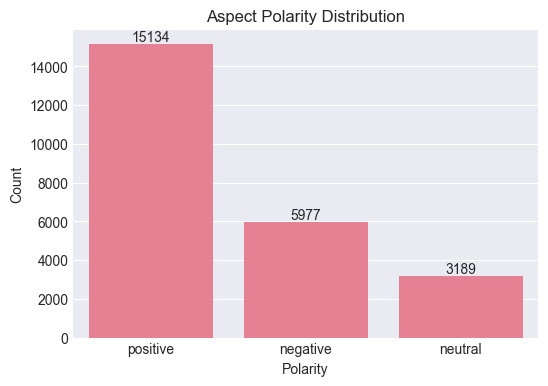

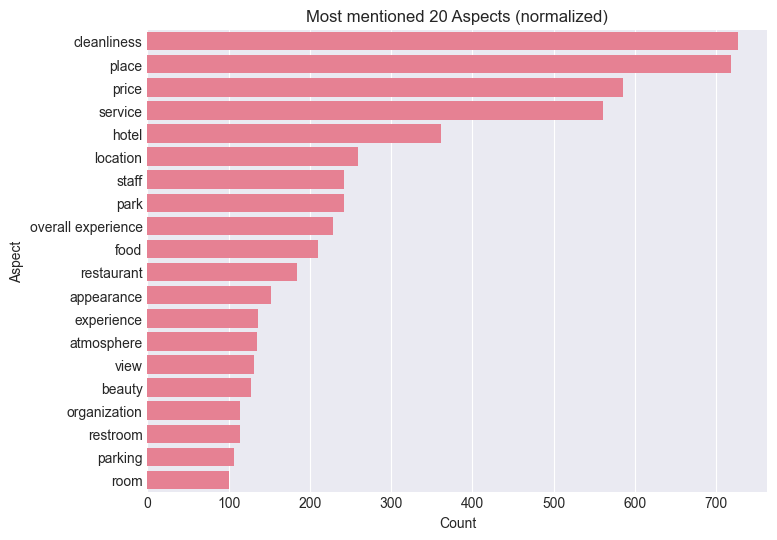

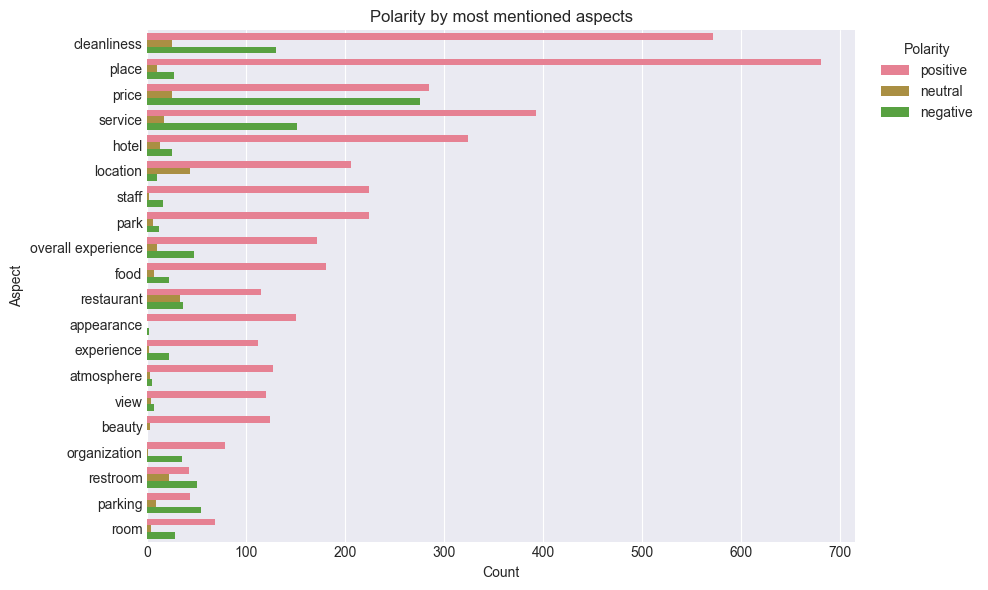

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Polarity distribution
plt.figure(figsize=(6,4))
sns.countplot(data=aspects_df, x='polarity', order=aspects_df['polarity'].value_counts().index)
plt.title('Aspect Polarity Distribution')
plt.xlabel('Polarity')
plt.ylabel('Count')
for i, v in enumerate(aspects_df['polarity'].value_counts().values):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.show()

# Top aspects overall (using normalized)
top_aspects = aspects_df['aspect_normalized'].value_counts().head(20)
plt.figure(figsize=(8,6))
sns.barplot(x=top_aspects.values, y=top_aspects.index)
plt.title('Most mentioned 20 Aspects (normalized)')
plt.xlabel('Count')
plt.ylabel('Aspect')
plt.show()

# Polarity by top aspects
top_list = set(top_aspects.index)
sub = aspects_df[aspects_df['aspect_normalized'].isin(top_list)]
plt.figure(figsize=(10,6))
sns.countplot(data=sub, y='aspect_normalized', hue='polarity', order=top_aspects.index)
plt.title('Polarity by most mentioned aspects')
plt.xlabel('Count')
plt.ylabel('Aspect')
plt.legend(title='Polarity', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Offering and destination breakdowns

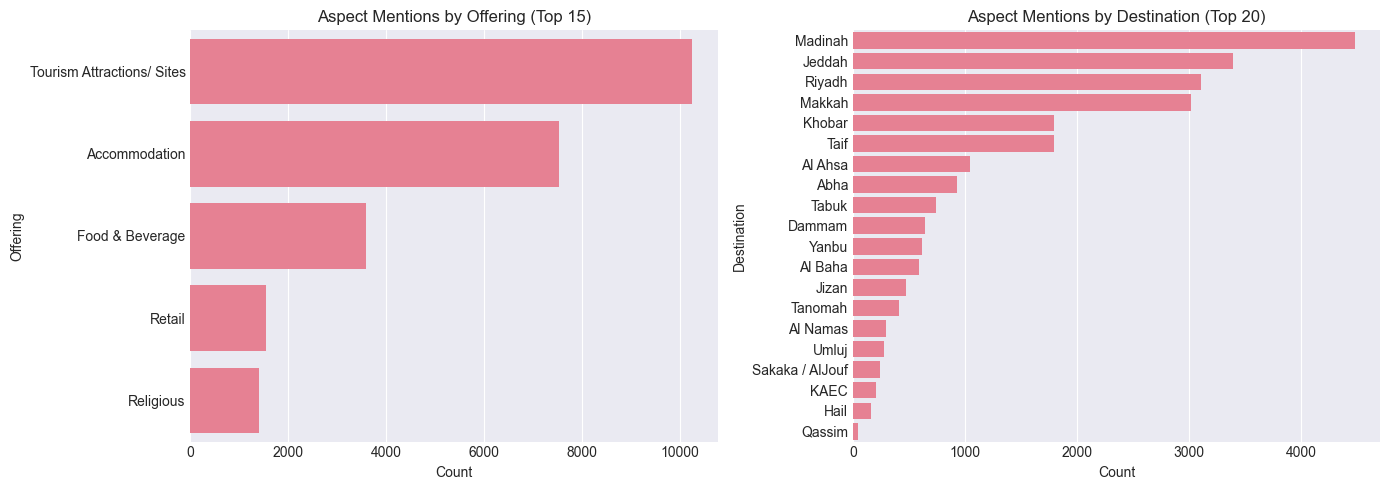

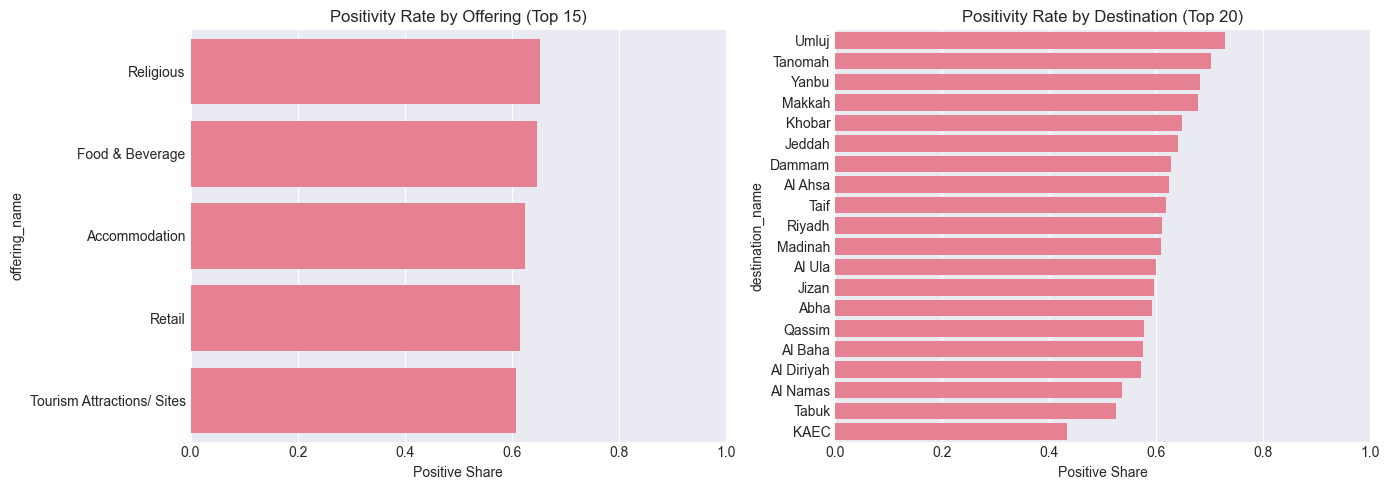

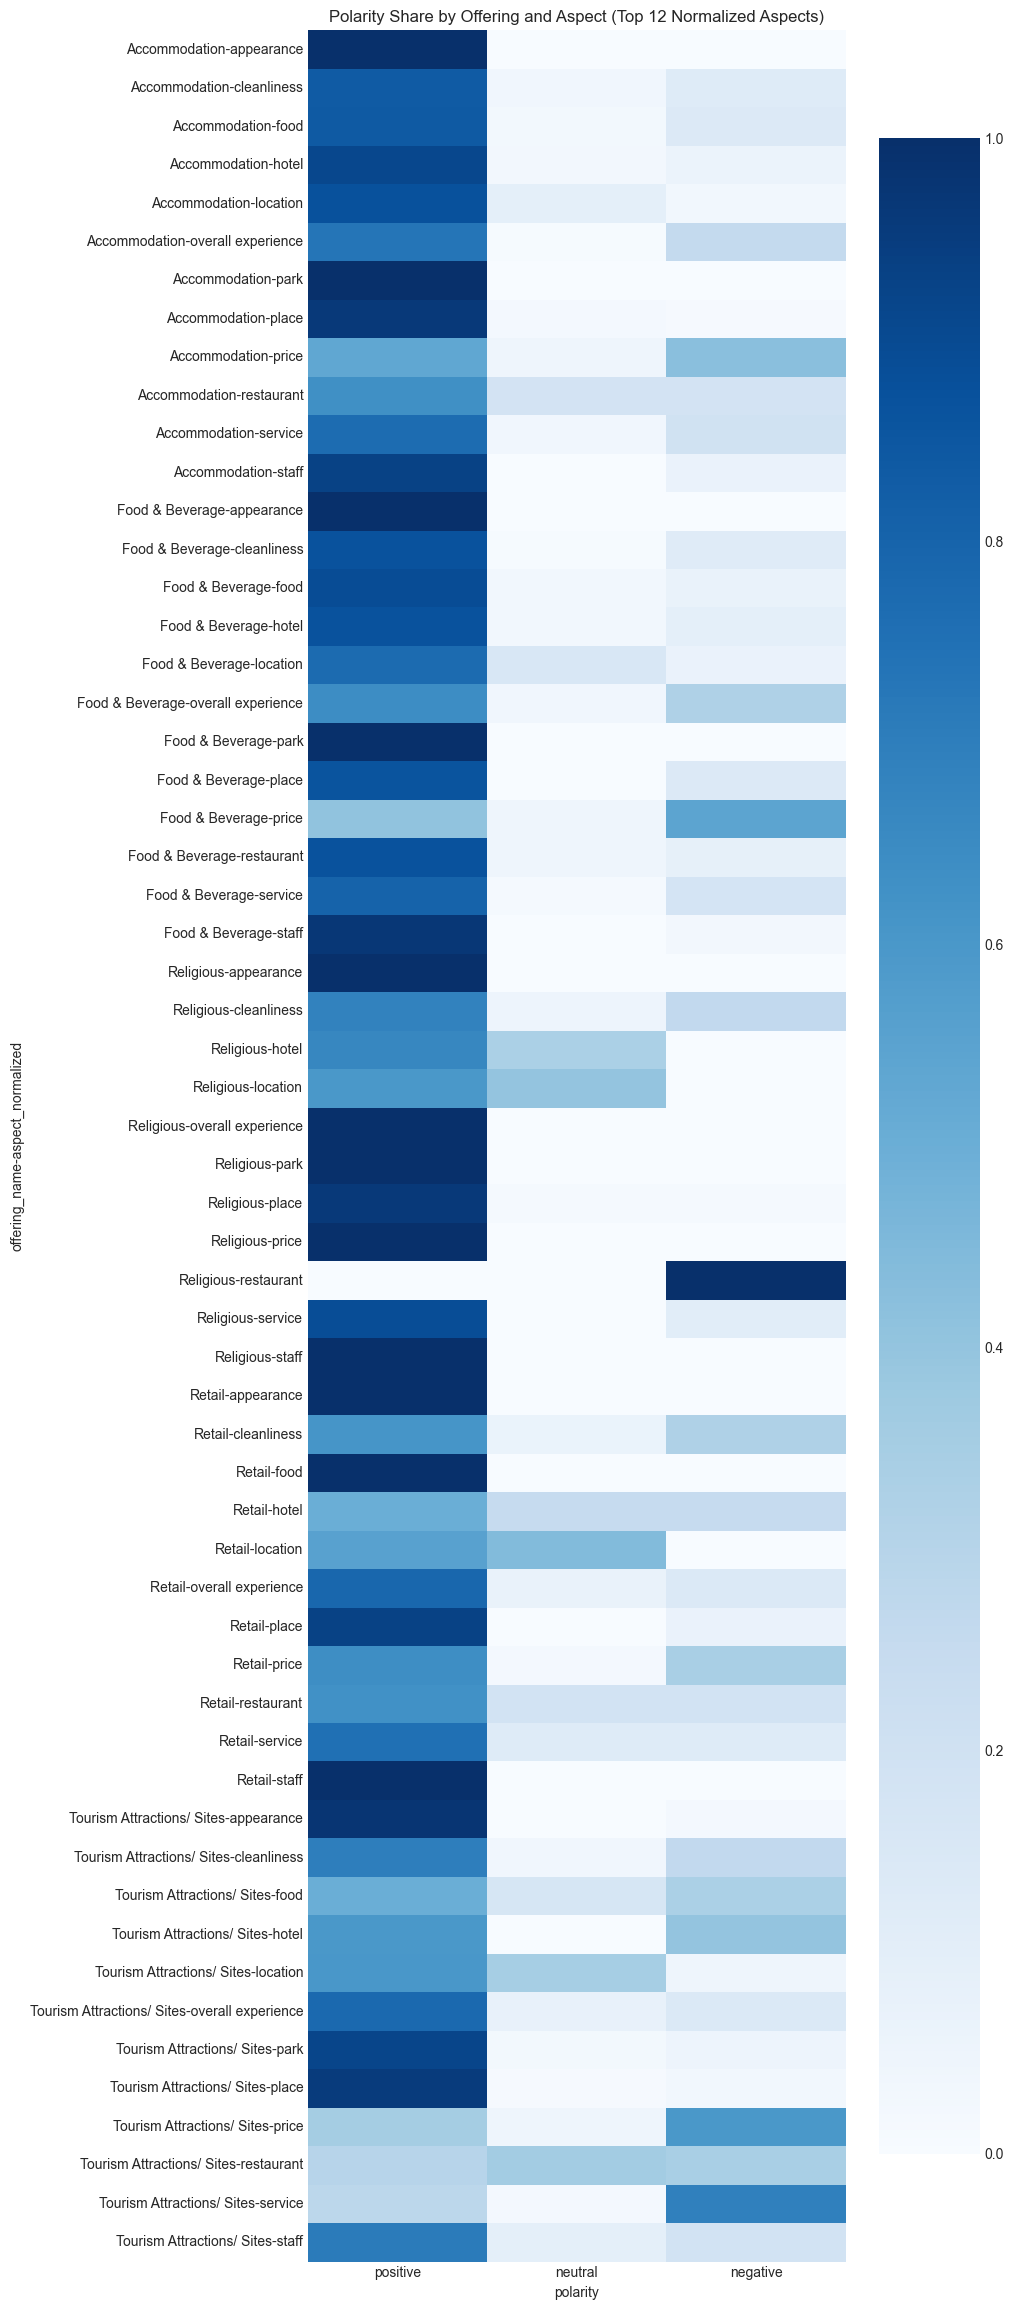

In [7]:
# Aspect counts by offering and destination
by_offering = aspects_df.groupby('offering_name').size().sort_values(ascending=False).head(15)
by_destination = aspects_df.groupby('destination_name').size().sort_values(ascending=False).head(20)

fig, axes = plt.subplots(1,2, figsize=(14,5))
sns.barplot(x=by_offering.values, y=by_offering.index, ax=axes[0])
axes[0].set_title('Aspect Mentions by Offering (Top 15)')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Offering')

sns.barplot(x=by_destination.values, y=by_destination.index, ax=axes[1])
axes[1].set_title('Aspect Mentions by Destination (Top 20)')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Destination')
plt.tight_layout()
plt.show()

# Positivity rate by offering and destination
def positivity_rate(g):
    return (g['polarity'].astype(str).str.lower().eq('positive').mean())

pos_by_off = aspects_df.groupby('offering_name').apply(positivity_rate).sort_values(ascending=False)
pos_by_dest = aspects_df.groupby('destination_name').apply(positivity_rate).sort_values(ascending=False)

fig, axes = plt.subplots(1,2, figsize=(14,5))
sns.barplot(x=pos_by_off.head(15).values, y=pos_by_off.head(15).index, ax=axes[0])
axes[0].set_title('Positivity Rate by Offering (Top 15)')
axes[0].set_xlabel('Positive Share')
axes[0].set_xlim(0,1)

sns.barplot(x=pos_by_dest.head(20).values, y=pos_by_dest.head(20).index, ax=axes[1])
axes[1].set_title('Positivity Rate by Destination (Top 20)')
axes[1].set_xlabel('Positive Share')
axes[1].set_xlim(0,1)
plt.tight_layout()
plt.show()

# Heatmap: polarity share by offering (top normalized aspects)
focus_aspects = aspects_df['aspect_normalized'].value_counts().head(12).index.tolist()
sub = aspects_df[aspects_df['aspect_normalized'].isin(focus_aspects)].copy()
sub = sub.dropna(subset=['offering_name','aspect_normalized','polarity'])
sub['polarity'] = sub['polarity'].astype(str).str.lower()

hm_counts = (
    sub.groupby(['offering_name','aspect_normalized','polarity'])
       .size()
       .reset_index(name='n')
)
# Normalize within each (offering_name, aspect_normalized)
hm_counts['share'] = hm_counts['n'] / hm_counts.groupby(['offering_name','aspect_normalized'])['n'].transform('sum')

pivot = hm_counts.pivot_table(index=['offering_name','aspect_normalized'], columns='polarity', values='share', fill_value=0)
# Optional: order polarity columns
pol_order = ['positive','neutral','negative']
existing = [c for c in pol_order if c in pivot.columns]
pivot = pivot.reindex(columns=existing + [c for c in pivot.columns if c not in existing])

plt.figure(figsize=(10, max(8, 0.4*len(pivot))))
sns.heatmap(pivot, cmap='Blues')
plt.title('Polarity Share by Offering and Aspect (Top 12 Normalized Aspects)')
plt.tight_layout()
plt.show()

## Temporal trends

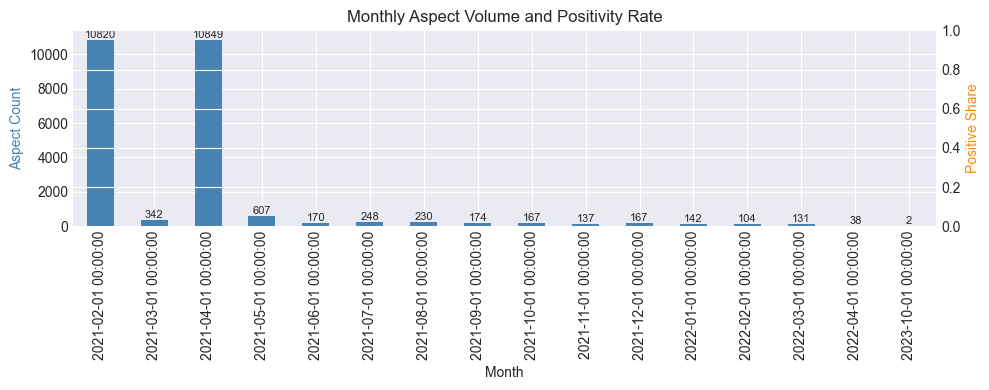

In [8]:
# Monthly aspect counts and positivity rate
aspects_df['month'] = pd.to_datetime(aspects_df['review_date']).dt.to_period('M').dt.to_timestamp()
by_month = aspects_df.groupby('month').size().rename('count').to_frame()
by_month['positive_share'] = aspects_df.groupby('month')['polarity'].apply(lambda s: s.str.lower().eq('positive').mean())

fig, ax1 = plt.subplots(figsize=(10,4))
by_month['count'].plot(kind='bar', ax=ax1, color='steelblue')
ax1.set_ylabel('Aspect Count', color='steelblue')
ax1.set_xlabel('Month')

ax2 = ax1.twinx()
ax2.plot(by_month.index, by_month['positive_share'], color='darkorange', marker='o')
ax2.set_ylabel('Positive Share', color='darkorange')
ax2.set_ylim(0,1)

for x, v in enumerate(by_month['count'].values):
    ax1.text(x, v, str(v), ha='center', va='bottom', fontsize=8)

plt.title('Monthly Aspect Volume and Positivity Rate')
plt.tight_layout()
plt.show()

## Approach, model, and confidence

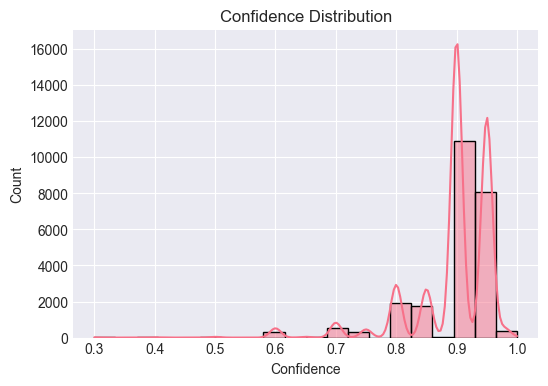

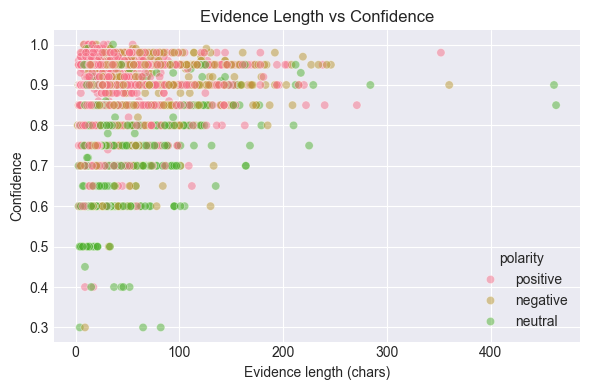

In [9]:
# Confidence distribution
plt.figure(figsize=(6,4))
sns.histplot(aspects_df['confidence'].dropna(), bins=20, kde=True)
plt.title('Confidence Distribution')
plt.xlabel('Confidence')
plt.show()

# Positivity by approach/model
# pivot_model = (aspects_df.assign(is_pos=aspects_df['polarity'].str.lower().eq('positive'))
#                .groupby(['approach','model'])['is_pos']
#                .mean().reset_index())
# plt.figure(figsize=(10,5))
# sns.barplot(data=pivot_model, x='is_pos', y='model', hue='approach')
# plt.title('Positive Share by Approach and Model')
# plt.xlabel('Positive Share')
# plt.xlim(0,1)
# plt.tight_layout()
# plt.show()

# Evidence length vs confidence
aspects_df['evidence_len'] = aspects_df['evidence_span'].fillna('').str.len()
plt.figure(figsize=(6,4))
sns.scatterplot(data=aspects_df, x='evidence_len', y='confidence', hue='polarity', alpha=0.5)
plt.title('Evidence Length vs Confidence')
plt.xlabel('Evidence length (chars)')
plt.ylabel('Confidence')
plt.tight_layout()
plt.show()

## Negative-focused analysis
We’ll dig into negative polarity to surface actionable areas: most complained-about aspects, offerings/destinations with higher negative share, trends over time, and example evidence.

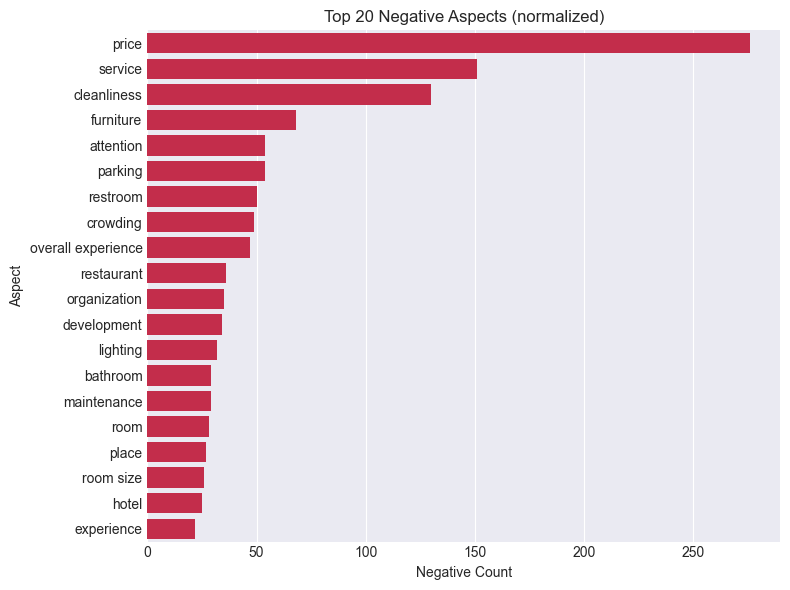

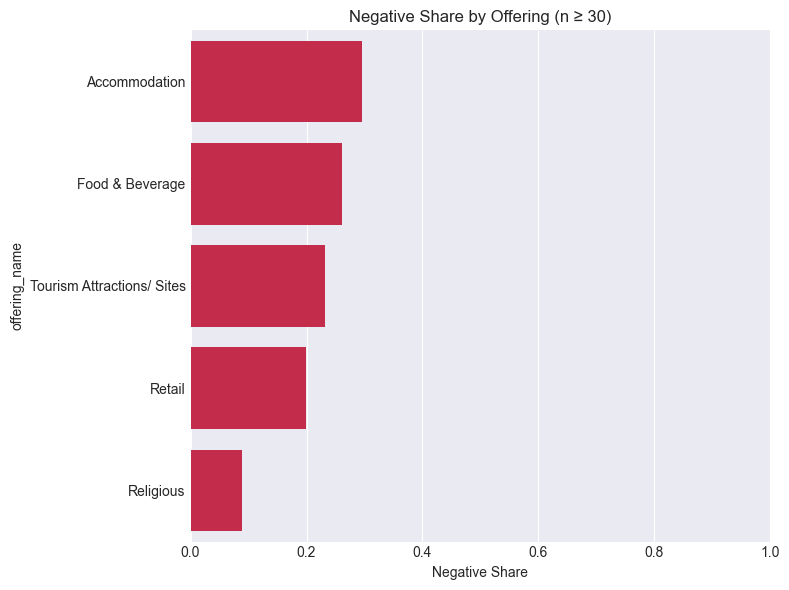

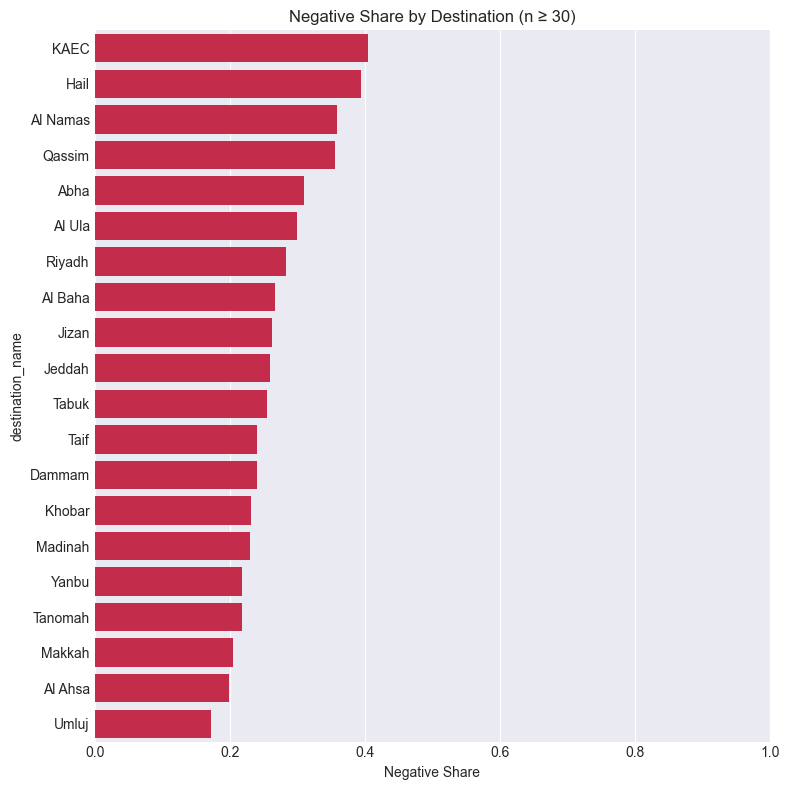

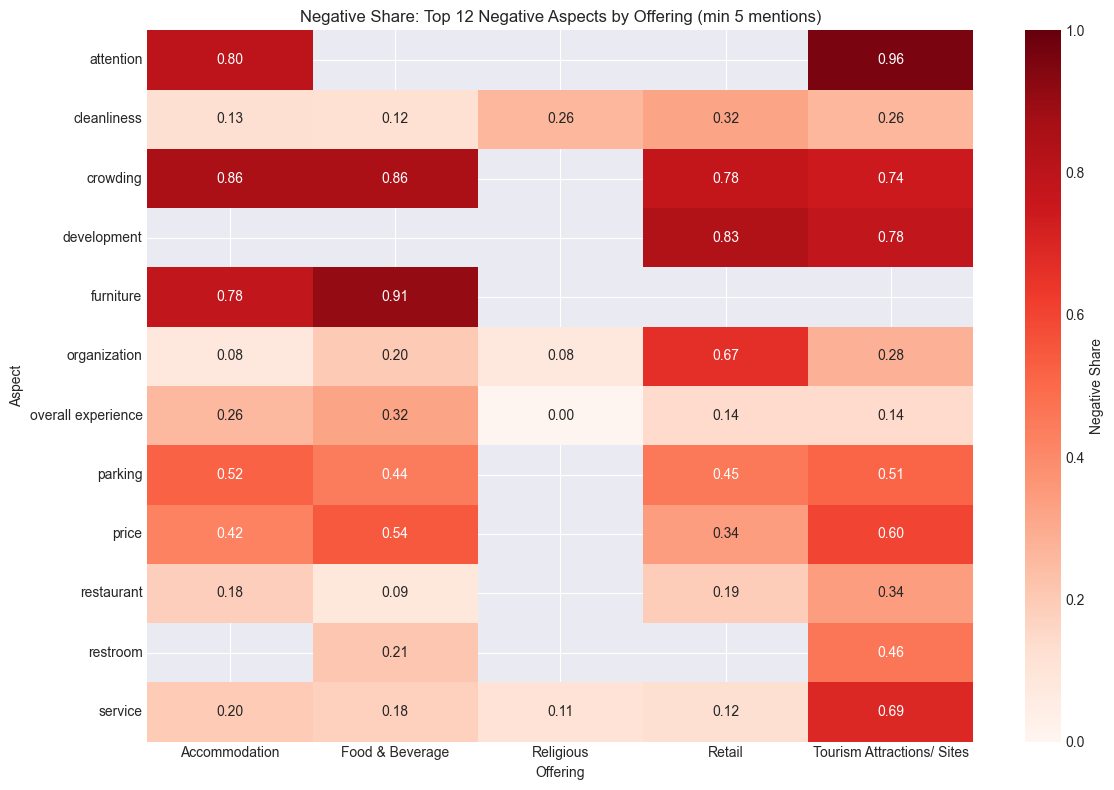

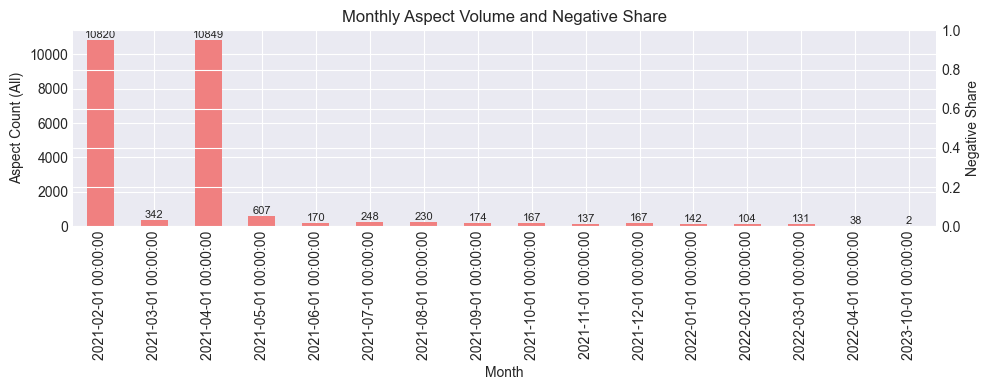

Top negative evidence (by confidence):


,destination_name,offering_name,aspect,aspect_normalized,category,evidence_span,confidence,rating_normalized
2519,Riyadh,Food & Beverage,Wi‑Fi,wi‑fi,None,no Wi‑Fi,1.00,20.0
8955,Madinah,Accommodation,hotel closure,hotel closure,None,The hotel is closed.,1.00,20.0
8139,Taif,Tourism Attractions/ Sites,bikes,bike,None,Bikes are not allowed,0.99,60.0
5411,Madinah,Food & Beverage,coffee,coffee,None,Bad coffee,0.99,20.0
5412,Madinah,Food & Beverage,customer service,customer service,None,awful customer service,0.99,20.0
7721,Taif,Tourism Attractions/ Sites,Al-Soudah,al-soudah,None,"Al-Soudah which is a mess, disgusting and full of savages.",0.99,100.0
8140,Taif,Tourism Attractions/ Sites,climbing the rocks,climbing the rock,None,climbing the rocks is prohibited.,0.99,60.0
10715,Dammam,Accommodation,cleaning service,cleaning service,None,their cleaning service is as bad as it gets — you have to call dozens of times before they bother to come and clean ...,0.99,40.0
5993,Tabuk,Religious,room door height,room door height,None,The room door is 150 cm high—you have to duck to enter.,0.99,80.0
370,Khobar,Accommodation,smell,smell,None,It smelled disgusting,0.99,20.0


In [10]:
# Helper: normalized polarity
pol = aspects_df['polarity'].astype(str).str.lower().fillna('')
neg_mask = pol.eq('negative')

# 1) Top negative aspects (using normalized)
neg_aspects = aspects_df[neg_mask]['aspect_normalized'].value_counts().head(20)
plt.figure(figsize=(8,6))
sns.barplot(x=neg_aspects.values, y=neg_aspects.index, color='crimson')
plt.title('Top 20 Negative Aspects (normalized)')
plt.xlabel('Negative Count')
plt.ylabel('Aspect')
plt.tight_layout()
plt.show()

# 2) Highest negative share by offering/destination (min volume filter)
MIN_ROWS = 30
agg = (aspects_df
       .assign(is_neg=pol.eq('negative'))
       .groupby('offering_name')
       .agg(n=('is_neg','size'), neg_share=('is_neg','mean'))
       .query('n >= @MIN_ROWS')
       .sort_values('neg_share', ascending=False))
plt.figure(figsize=(8,6))
sns.barplot(data=agg.head(15), x='neg_share', y=agg.head(15).index, color='crimson')
plt.title('Negative Share by Offering (n ≥ 30)')
plt.xlabel('Negative Share')
plt.xlim(0,1)
plt.tight_layout()
plt.show()

agg_d = (aspects_df
         .assign(is_neg=pol.eq('negative'))
         .groupby('destination_name')
         .agg(n=('is_neg','size'), neg_share=('is_neg','mean'))
         .query('n >= @MIN_ROWS')
         .sort_values('neg_share', ascending=False))
plt.figure(figsize=(8,8))
sns.barplot(data=agg_d.head(20), x='neg_share', y=agg_d.head(20).index, color='crimson')
plt.title('Negative Share by Destination (n ≥ 30)')
plt.xlabel('Negative Share')
plt.xlim(0,1)
plt.tight_layout()
plt.show()

# 3) Heatmap: negative share by aspect (rows) and offering (columns)
# Filter to avoid misleading percentages from low-count combinations
MIN_ASPECT_MENTIONS = 5  # minimum mentions per aspect-offering combo
focus_neg_aspects = aspects_df[neg_mask]['aspect_normalized'].value_counts().head(12).index.tolist()
subn = aspects_df[aspects_df['aspect_normalized'].isin(focus_neg_aspects)].copy()
subn = subn.dropna(subset=['offering_name','aspect_normalized'])
subn['is_neg'] = subn['polarity'].astype(str).str.lower().eq('negative')

# Calculate both count and negative share
hmn = (subn.groupby(['aspect_normalized','offering_name'])
       .agg(total_count=('is_neg','size'), neg_share=('is_neg','mean'))
       .reset_index())

# Filter out combinations with too few mentions
hmn_filtered = hmn[hmn['total_count'] >= MIN_ASPECT_MENTIONS].copy()

pivotn = hmn_filtered.pivot_table(index='aspect_normalized', columns='offering_name', values='neg_share')
plt.figure(figsize=(12, 8))
sns.heatmap(pivotn, cmap='Reds', vmin=0, vmax=1, annot=True, fmt='.2f', cbar_kws={'label': 'Negative Share'})
plt.title(f'Negative Share: Top 12 Negative Aspects by Offering (min {MIN_ASPECT_MENTIONS} mentions)')
plt.xlabel('Offering')
plt.ylabel('Aspect')
plt.tight_layout()
plt.show()

# 4) Negative trend over time
aspects_df['month'] = pd.to_datetime(aspects_df['review_date']).dt.to_period('M').dt.to_timestamp()
by_m = (aspects_df.assign(is_neg=pol.eq('negative'))
        .groupby('month')
        .agg(count=('is_neg','size'), neg_share=('is_neg','mean')))
fig, ax1 = plt.subplots(figsize=(10,4))
by_m['count'].plot(kind='bar', ax=ax1, color='lightcoral')
ax1.set_ylabel('Aspect Count (All)')
ax1.set_xlabel('Month')
ax2 = ax1.twinx()
ax2.plot(by_m.index, by_m['neg_share'], color='crimson', marker='o')
ax2.set_ylabel('Negative Share')
ax2.set_ylim(0,1)
for x, v in enumerate(by_m['count'].values):
    ax1.text(x, v, str(v), ha='center', va='bottom', fontsize=8)
plt.title('Monthly Aspect Volume and Negative Share')
plt.tight_layout()
plt.show()

# 5) Sample negative evidence (high-confidence, showing both original and normalized)
samples = (aspects_df
           .assign(is_neg=pol.eq('negative'))
           .query('is_neg')
           .sort_values('confidence', ascending=False)
           .head(10)[['destination_name','offering_name','aspect','aspect_normalized','category','evidence_span','confidence','rating_normalized']])
print('Top negative evidence (by confidence):')
display(samples)

## Insights summary
Quick toplines you can paste into a report: key negative aspects, offerings/destinations with higher negatives, and recent trend.

In [11]:
# Compute succinct toplines (using normalized aspects)
pol = aspects_df['polarity'].astype(str).str.lower()
neg_aspect_counts = aspects_df[pol.eq('negative')]['aspect_normalized'].value_counts()

MIN_ROWS = 30
neg_by_off = (aspects_df.assign(is_neg=pol.eq('negative'))
              .groupby('offering_name')
              .agg(n=('is_neg','size'), neg_share=('is_neg','mean'))
              .query('n >= @MIN_ROWS')
              .sort_values('neg_share', ascending=False))
neg_by_dest = (aspects_df.assign(is_neg=pol.eq('negative'))
               .groupby('destination_name')
               .agg(n=('is_neg','size'), neg_share=('is_neg','mean'))
               .query('n >= @MIN_ROWS')
               .sort_values('neg_share', ascending=False))

by_m = (aspects_df.assign(is_neg=pol.eq('negative'))
        .groupby(pd.to_datetime(aspects_df['review_date']).dt.to_period('M').dt.to_timestamp())
        .agg(count=('is_neg','size'), neg_share=('is_neg','mean')))

def pct(x):
    return f"{100*x:.1f}%"

lines = []
lines.append(f"Top negative aspects: {', '.join(neg_aspect_counts.head(5).index.tolist())}")
if not neg_by_off.empty:
    lines.append(f"Offerings with highest negative share (n≥{MIN_ROWS}): " + ', '.join([f"{idx} ({pct(row.neg_share)})" for idx, row in neg_by_off.head(5).iterrows()]))
if not neg_by_dest.empty:
    lines.append(f"Destinations with highest negative share (n≥{MIN_ROWS}): " + ', '.join([f"{idx} ({pct(row.neg_share)})" for idx, row in neg_by_dest.head(5).iterrows()]))

print('\n'.join(lines))

Top negative aspects: price, service, cleanliness, furniture, attention
Offerings with highest negative share (n≥30): Accommodation (29.5%), Food & Beverage (26.1%), Tourism Attractions/ Sites (23.2%), Retail (19.9%), Religious (8.8%)
Destinations with highest negative share (n≥30): KAEC (40.5%), Hail (39.4%), Al Namas (35.9%), Qassim (35.6%), Abha (31.0%)
